In [ ]:
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn
from sklego.meta.estimator_transformer import EstimatorTransformer
from scores.probability import crps_cdf
import pandas as pd
from functools import partial
from scipy import stats

from src.marginal_bootstrap import *

In [15]:
import warnings

warnings.filterwarnings("ignore")

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
sklearn.set_config(enable_metadata_routing=True)

In [18]:
plt.style.use("bmh")

In [130]:
SEED = 42
SAMPLE = 200
BOOTSTRAPS_OUTER = 1000
BOOTSTRAPS_INNER = 500

RUNS = 1500

statistic_of_interest = partial(np.median, axis=0)

distribution = stats.beta(9, 1)

TRUE_MEAN = distribution.stats()[0]

random_generator = np.random.default_rng(SEED)
sample = distribution.rvs(SAMPLE, random_state=random_generator)

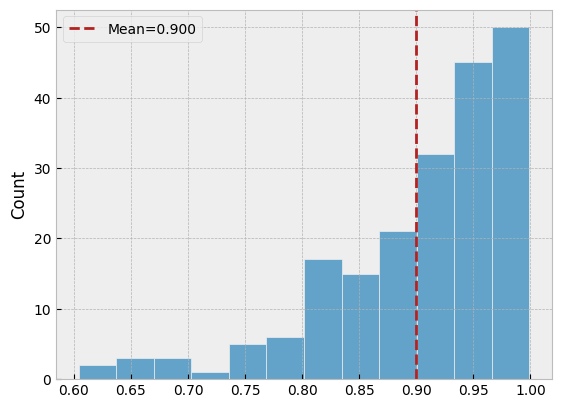

In [131]:
sns.histplot(sample)
plt.axvline(TRUE_MEAN, color="firebrick", linestyle="--", label=f"Mean={TRUE_MEAN:.3f}")
plt.legend();

In [20]:
bootstrap_methods = {
    "bayesian": bootstrap_bayesian,
    "jitter": bootstrap_with_jitter,
    "non_parametric": bootstrap_non_parametric,
    "kde": bootstrap_kde,
}

In [ ]:
runs = []
for method_name, method in tqdm(bootstrap_methods.items(), desc="Outer Loop", position=0):
    outer_bootstraps = bootstrap_non_parametric(sample, bootstrap_size=BOOTSTRAPS_OUTER, random_generator=random_generator)
    for inner_index, outer_bootstrap in tqdm(enumerate(outer_bootstraps.T), total=BOOTSTRAPS_OUTER, desc=f"Inner Loop - {method_name}"):
        inner_bootstrap = method(outer_bootstrap, bootstrap_size=BOOTSTRAPS_INNER, random_generator=random_generator)
        result = inner_index, method_name, statistic_of_interest(inner_bootstrap)
        runs.append(result)

Outer Loop:   0%|          | 0/4 [00:00<?, ?it/s]

Inner Loop - bayesian:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop - jitter:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop - non_parametric:   0%|          | 0/100 [00:00<?, ?it/s]

Inner Loop - kde:   0%|          | 0/100 [00:00<?, ?it/s]

In [135]:
df = pd.DataFrame(runs, columns=["outer_index", "method", "means"]).explode("means")
df

,outer_index,method,means
0,0,bayesian,-0.033122
0,0,bayesian,-0.027444
0,0,bayesian,0.00328
0,0,bayesian,-0.017135
0,0,bayesian,-0.009467
...,...,...,...
399,99,kde,-0.636853
399,99,kde,0.3213
399,99,kde,-1.058787
399,99,kde,-0.514086


In [23]:
summary_df = (
    df.groupby(["method", "outer_index"])
    .agg(
        lower=("means", partial(np.quantile, q=0.025)),
        upper=("means", partial(np.quantile, q=0.975)),
    )
    .assign(
        width=lambda x: x.upper - x.lower,
        midpoint=lambda x: (x.upper + x.lower) / 2,
    )
    .reset_index(drop=False)
)
summary_df

,method,outer_index,lower,upper,width,midpoint
0,bayesian,0,-0.045848,0.013107,0.058955,-0.016371
1,bayesian,1,-0.009868,0.035801,0.045669,0.012967
2,bayesian,2,-0.046335,0.017454,0.063789,-0.014441
3,bayesian,3,-0.024663,0.021938,0.046602,-0.001363
4,bayesian,4,-0.006269,0.045573,0.051842,0.019652
...,...,...,...,...,...,...
395,non_parametric,95,-0.693502,1.090250,1.783752,0.198374
396,non_parametric,96,-0.453362,1.073439,1.526801,0.310038
397,non_parametric,97,-0.579534,0.863329,1.442864,0.141898
398,non_parametric,98,-0.078460,1.376316,1.454775,0.648928


In [24]:
def coverage_ratio(true_value, lower, upper):
    return np.mean((true_value >= lower) & (true_value <= upper))

In [25]:
def regression_mwi_score(
    y_true,
    lower,
    upper,
    confidence_level: float = 0.95
) -> float:

    y_pis = np.stack([lower, upper]).T[:, :, np.newaxis]
    y_pred_low = np.minimum(y_pis[:, 0, 0], y_pis[:, 1, 0])
    y_pred_up = np.maximum(y_pis[:, 0, 0], y_pis[:, 1, 0])

    width = np.sum(y_pred_up) - np.sum(y_pred_low)  # type: ignore
    error_above = np.sum((y_true - y_pred_up)[y_true > y_pred_up])
    error_below = np.sum((y_pred_low - y_true)[y_true < y_pred_low])
    total_error = error_above + error_below
    mwi = (width + total_error * 2 / (1 - confidence_level)) / len(lower)
    return mwi

In [26]:
def isd_from_kde(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)
    
    second_deriv = np.gradient(np.gradient(f_vals, dx), dx)
    
    isd = np.sum(second_deriv**2) * dx

    return isd

def entropy(samples, grid_size=20):
    kde = gaussian_kde(samples)
    x = np.linspace(min(samples), max(samples), grid_size)
    dx = x[1] - x[0]
    f_vals = kde(x)

    f_norm = f_vals / np.sum(f_vals * dx) 
    return -np.sum(f_norm * np.log(f_norm + 1e-12)) * dx

In [27]:
from scipy import stats
from scores.probability import crps_cdf
import xarray

def cprs(true_value, samples, grid_size=20):
    x = np.linspace(min(samples), max(samples), grid_size)
    fcst_cdf = stats.norm.cdf(x, loc=0)
    fcst_array = xarray.DataArray(coords={'temperature': x}, data=fcst_cdf)
    obs_array = xarray.DataArray(true_value)
    return crps_cdf(fcst_array, obs_array, threshold_dim='temperature').total.values.round(3)

In [28]:
runs_df = pd.concat([
    summary_df.groupby("method").sample(frac=1, replace=True, random_state=boot).assign(run=boot)
    for boot in range(RUNS)
])
runs_df

,method,outer_index,lower,upper,width,midpoint,run
44,bayesian,44,-0.008740,0.046300,0.055040,0.018780,0
47,bayesian,47,-0.079220,-0.017620,0.061601,-0.048420,0
64,bayesian,64,-0.000161,0.039740,0.039900,0.019790,0
67,bayesian,67,-0.034737,0.026474,0.061210,-0.004131,0
67,bayesian,67,-0.034737,0.026474,0.061210,-0.004131,0
...,...,...,...,...,...,...,...
371,non_parametric,71,-1.290032,0.359077,1.649109,-0.465478,49
378,non_parametric,78,-0.504746,0.891154,1.395900,0.193204,49
319,non_parametric,19,-0.970086,0.995360,1.965446,0.012637,49
377,non_parametric,77,-0.352733,1.244416,1.597149,0.445841,49


In [60]:
aggregated_metrics = {
    "coverage_ratio": lambda x: coverage_ratio(TRUE_MEAN, x.lower, x.upper),
    "mwi": lambda x: regression_mwi_score(TRUE_MEAN, x.lower, x.upper),
    "width_mean": lambda x: np.mean(x.upper - x.lower),
    "lower_std": lambda x: np.std(x.lower),
    "upper_std": lambda x: np.std(x.upper),
    "entropy_width": lambda x: entropy(x.width),
    "entropy_midpoint": lambda x: entropy(x.midpoint),
    "bias_midpoint": lambda x: np.mean(x.midpoint) - TRUE_MEAN,
}

grouped_runs = runs_df.groupby(["method", "run"])

aggregated_data = {}
for metric_name, metric in aggregated_metrics.items():
    aggregated_data[metric_name] = grouped_runs.apply(metric)

In [61]:
aggregated_df = pd.concat([
    dataframe.to_frame("value").assign(metric=metric_name)
    for metric_name, dataframe in aggregated_data.items()
]).reset_index()

In [62]:
data_metrics = {
    "log(isd)": lambda x: np.log(isd_from_kde(x.means.astype(np.float64))),
    "cprs": lambda x: cprs(TRUE_MEAN, x.means.astype(np.float64)),
    "bias_point": lambda x: np.mean(x.means) - TRUE_MEAN
                        
}

df_grouped = df.groupby(["method", "outer_index"])

data_aggregated_data = {}
for metric_name, metric in data_metrics.items():
    data_aggregated_data[metric_name] = df_grouped.apply(metric)

In [63]:
data_aggregated_df = pd.concat([
    dataframe.to_frame("value").assign(metric=metric_name)
    for metric_name, dataframe in data_aggregated_data.items()
]).reset_index()

In [64]:
study_summary_df = pd.concat([aggregated_df, data_aggregated_df]).drop(["run", "outer_index"], axis=1)
study_summary_df

,method,value,metric
0,bayesian,0.950000,coverage_ratio
1,bayesian,0.960000,coverage_ratio
2,bayesian,0.960000,coverage_ratio
3,bayesian,1.000000,coverage_ratio
4,bayesian,0.980000,coverage_ratio
...,...,...,...
1195,non_parametric,0.176061,bias_point
1196,non_parametric,0.346375,bias_point
1197,non_parametric,0.162623,bias_point
1198,non_parametric,0.660943,bias_point


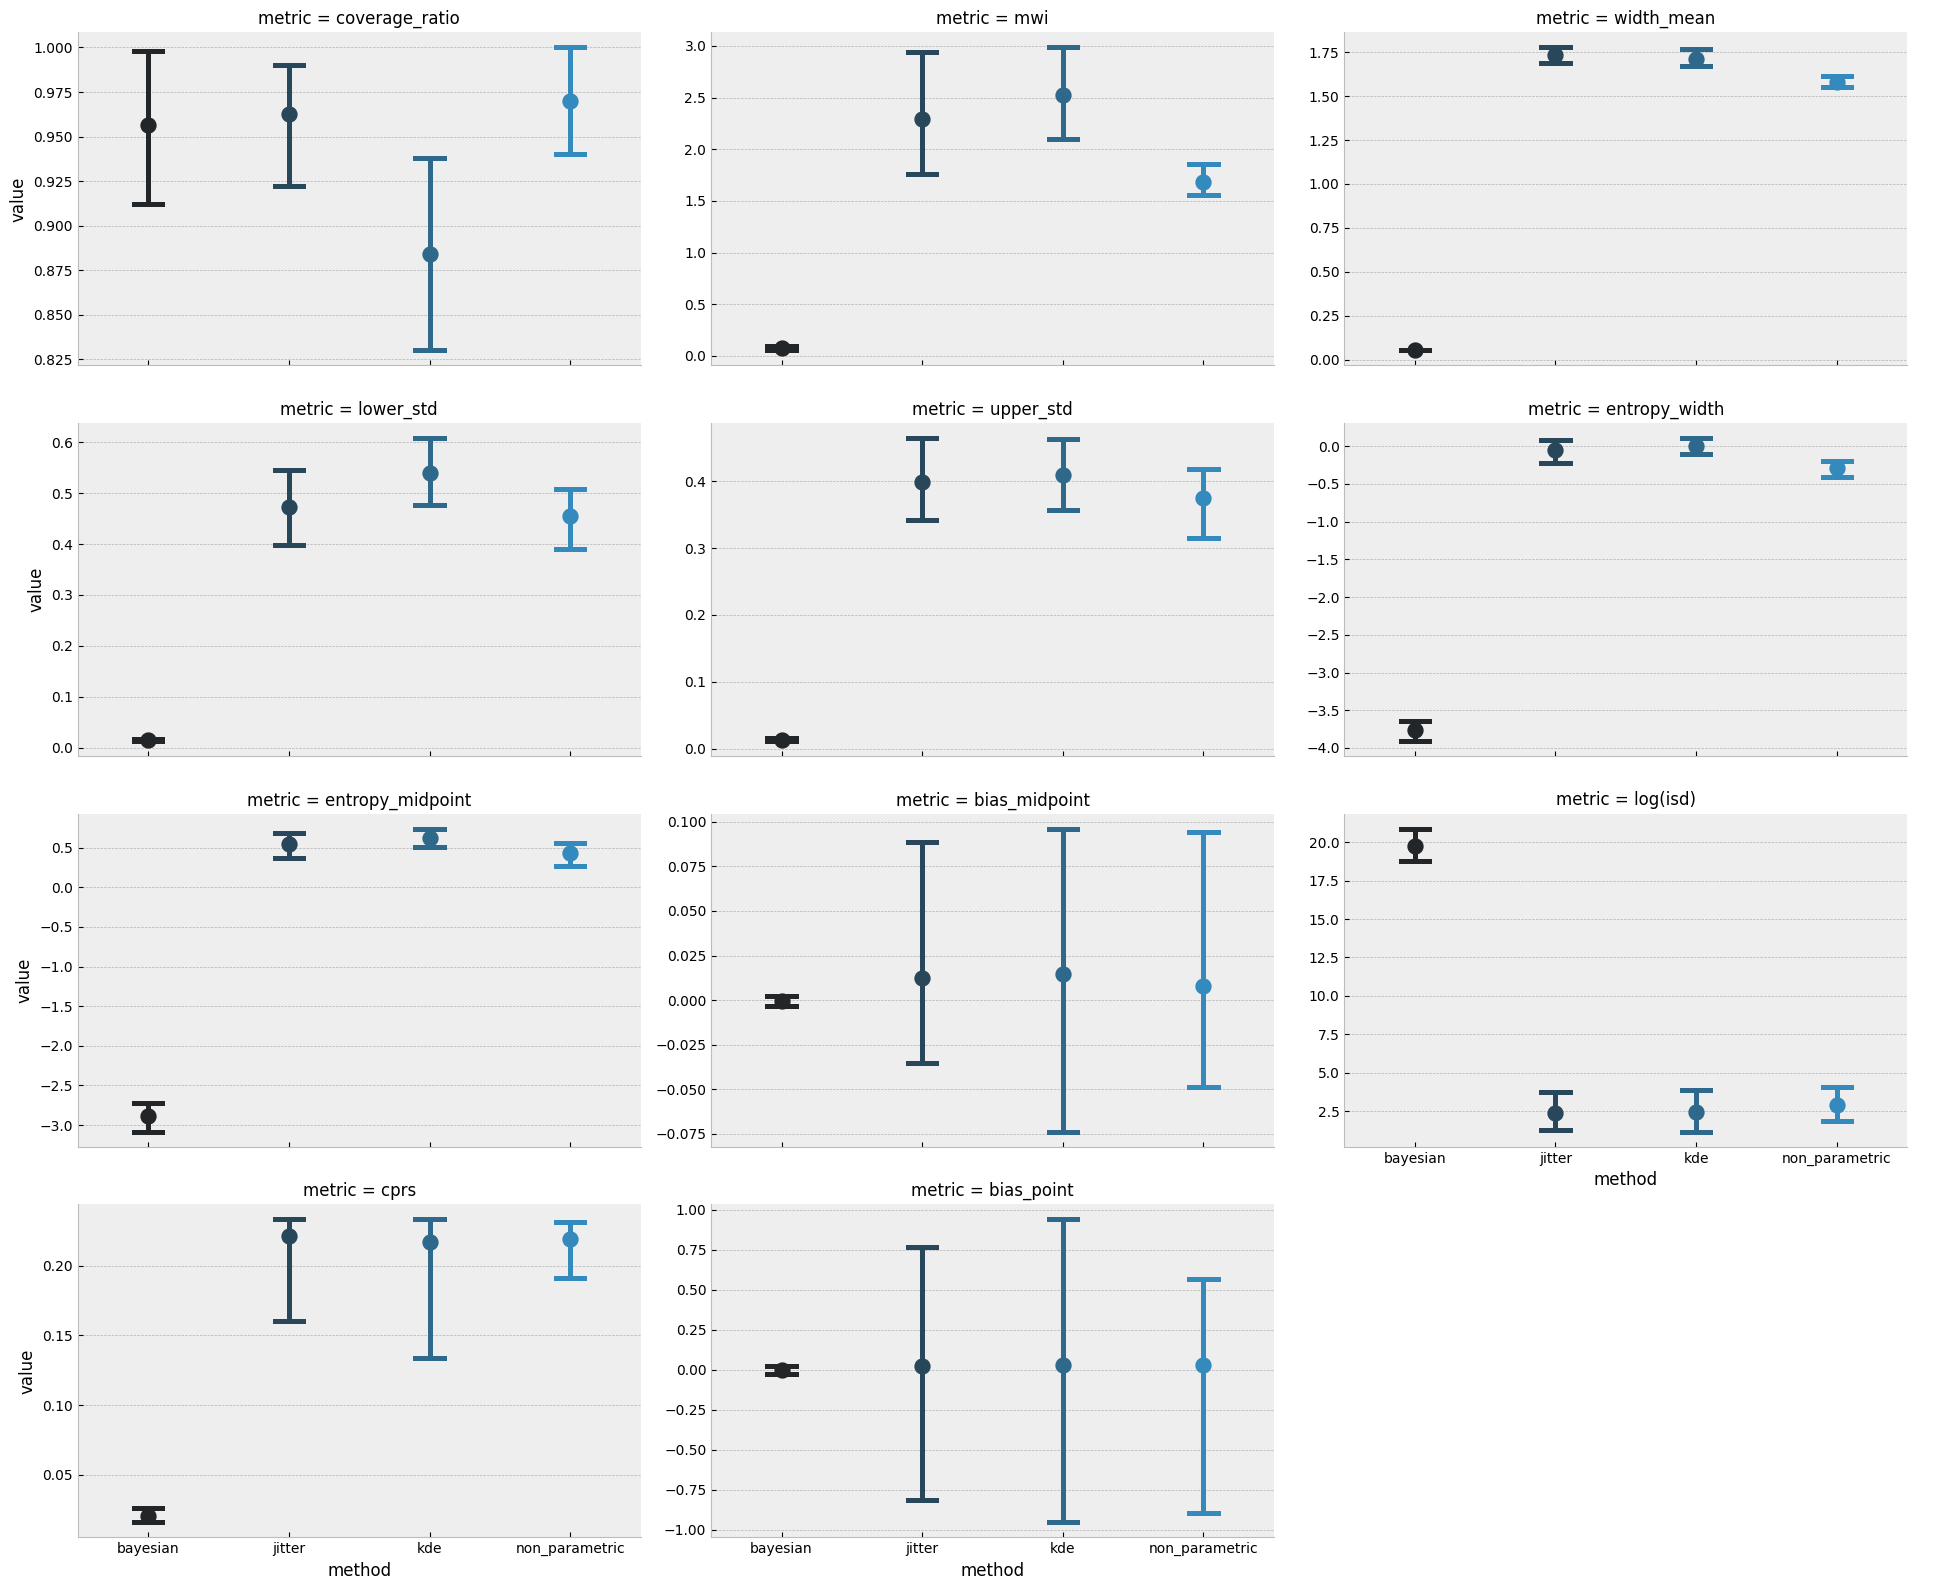

In [ ]:
facet = sns.FacetGrid(data=study_summary_df, col="metric", height=4, aspect=1.61, sharey=False, col_wrap=3)
facet.map_dataframe(sns.pointplot, x="method", hue="method", y="value", join=False, errorbar=("pi", 95), capsize=0.2)
facet.add_legend();

In [147]:
df

,outer_index,method,means
0,0,bayesian,-0.033122
0,0,bayesian,-0.027444
0,0,bayesian,0.00328
0,0,bayesian,-0.017135
0,0,bayesian,-0.009467
...,...,...,...
399,99,kde,-0.636853
399,99,kde,0.3213
399,99,kde,-1.058787
399,99,kde,-0.514086


In [153]:
data_stabilization_df = (
    df.groupby(["method"])
                    .expanding()
                    .mean()
                    .reset_index()
)
data_stabilization_df["level_1"] = data_stabilization_df.groupby(["method"]).cumcount()

In [154]:
data_stabilization_df

,method,level_1,outer_index,means
0,bayesian,0,0.00000,-0.033122
1,bayesian,1,0.00000,-0.030283
2,bayesian,2,0.00000,-0.019096
3,bayesian,3,0.00000,-0.018605
4,bayesian,4,0.00000,-0.016778
...,...,...,...,...
199995,non_parametric,49995,49.49604,0.028512
199996,non_parametric,49996,49.49703,0.028515
199997,non_parametric,49997,49.49802,0.028512
199998,non_parametric,49998,49.49901,0.028515


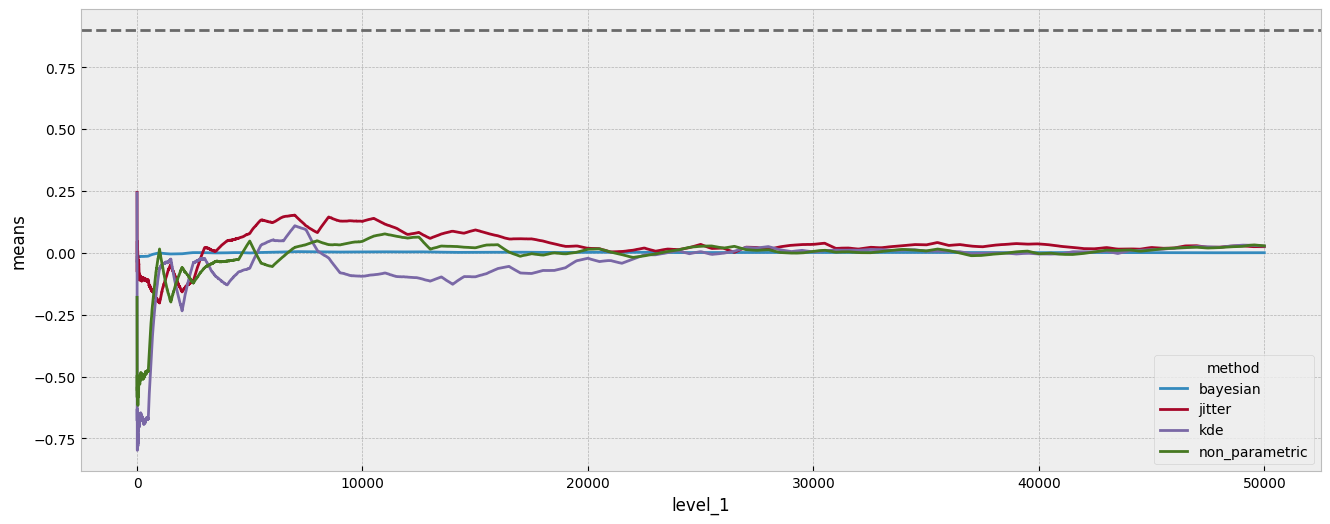

In [156]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=data_stabilization_df, x="level_1", hue="method", y="means", ax=ax)
ax.axhline(TRUE_MEAN, linestyle="--", color="dimgrey")

In [72]:
stabilization_df = (
    study_summary_df.groupby(["method", "metric"])
                    .expanding()
                    .mean()
                    .reset_index()
)
stabilization_df["level_2"] = stabilization_df.groupby(["method", "metric"]).cumcount()

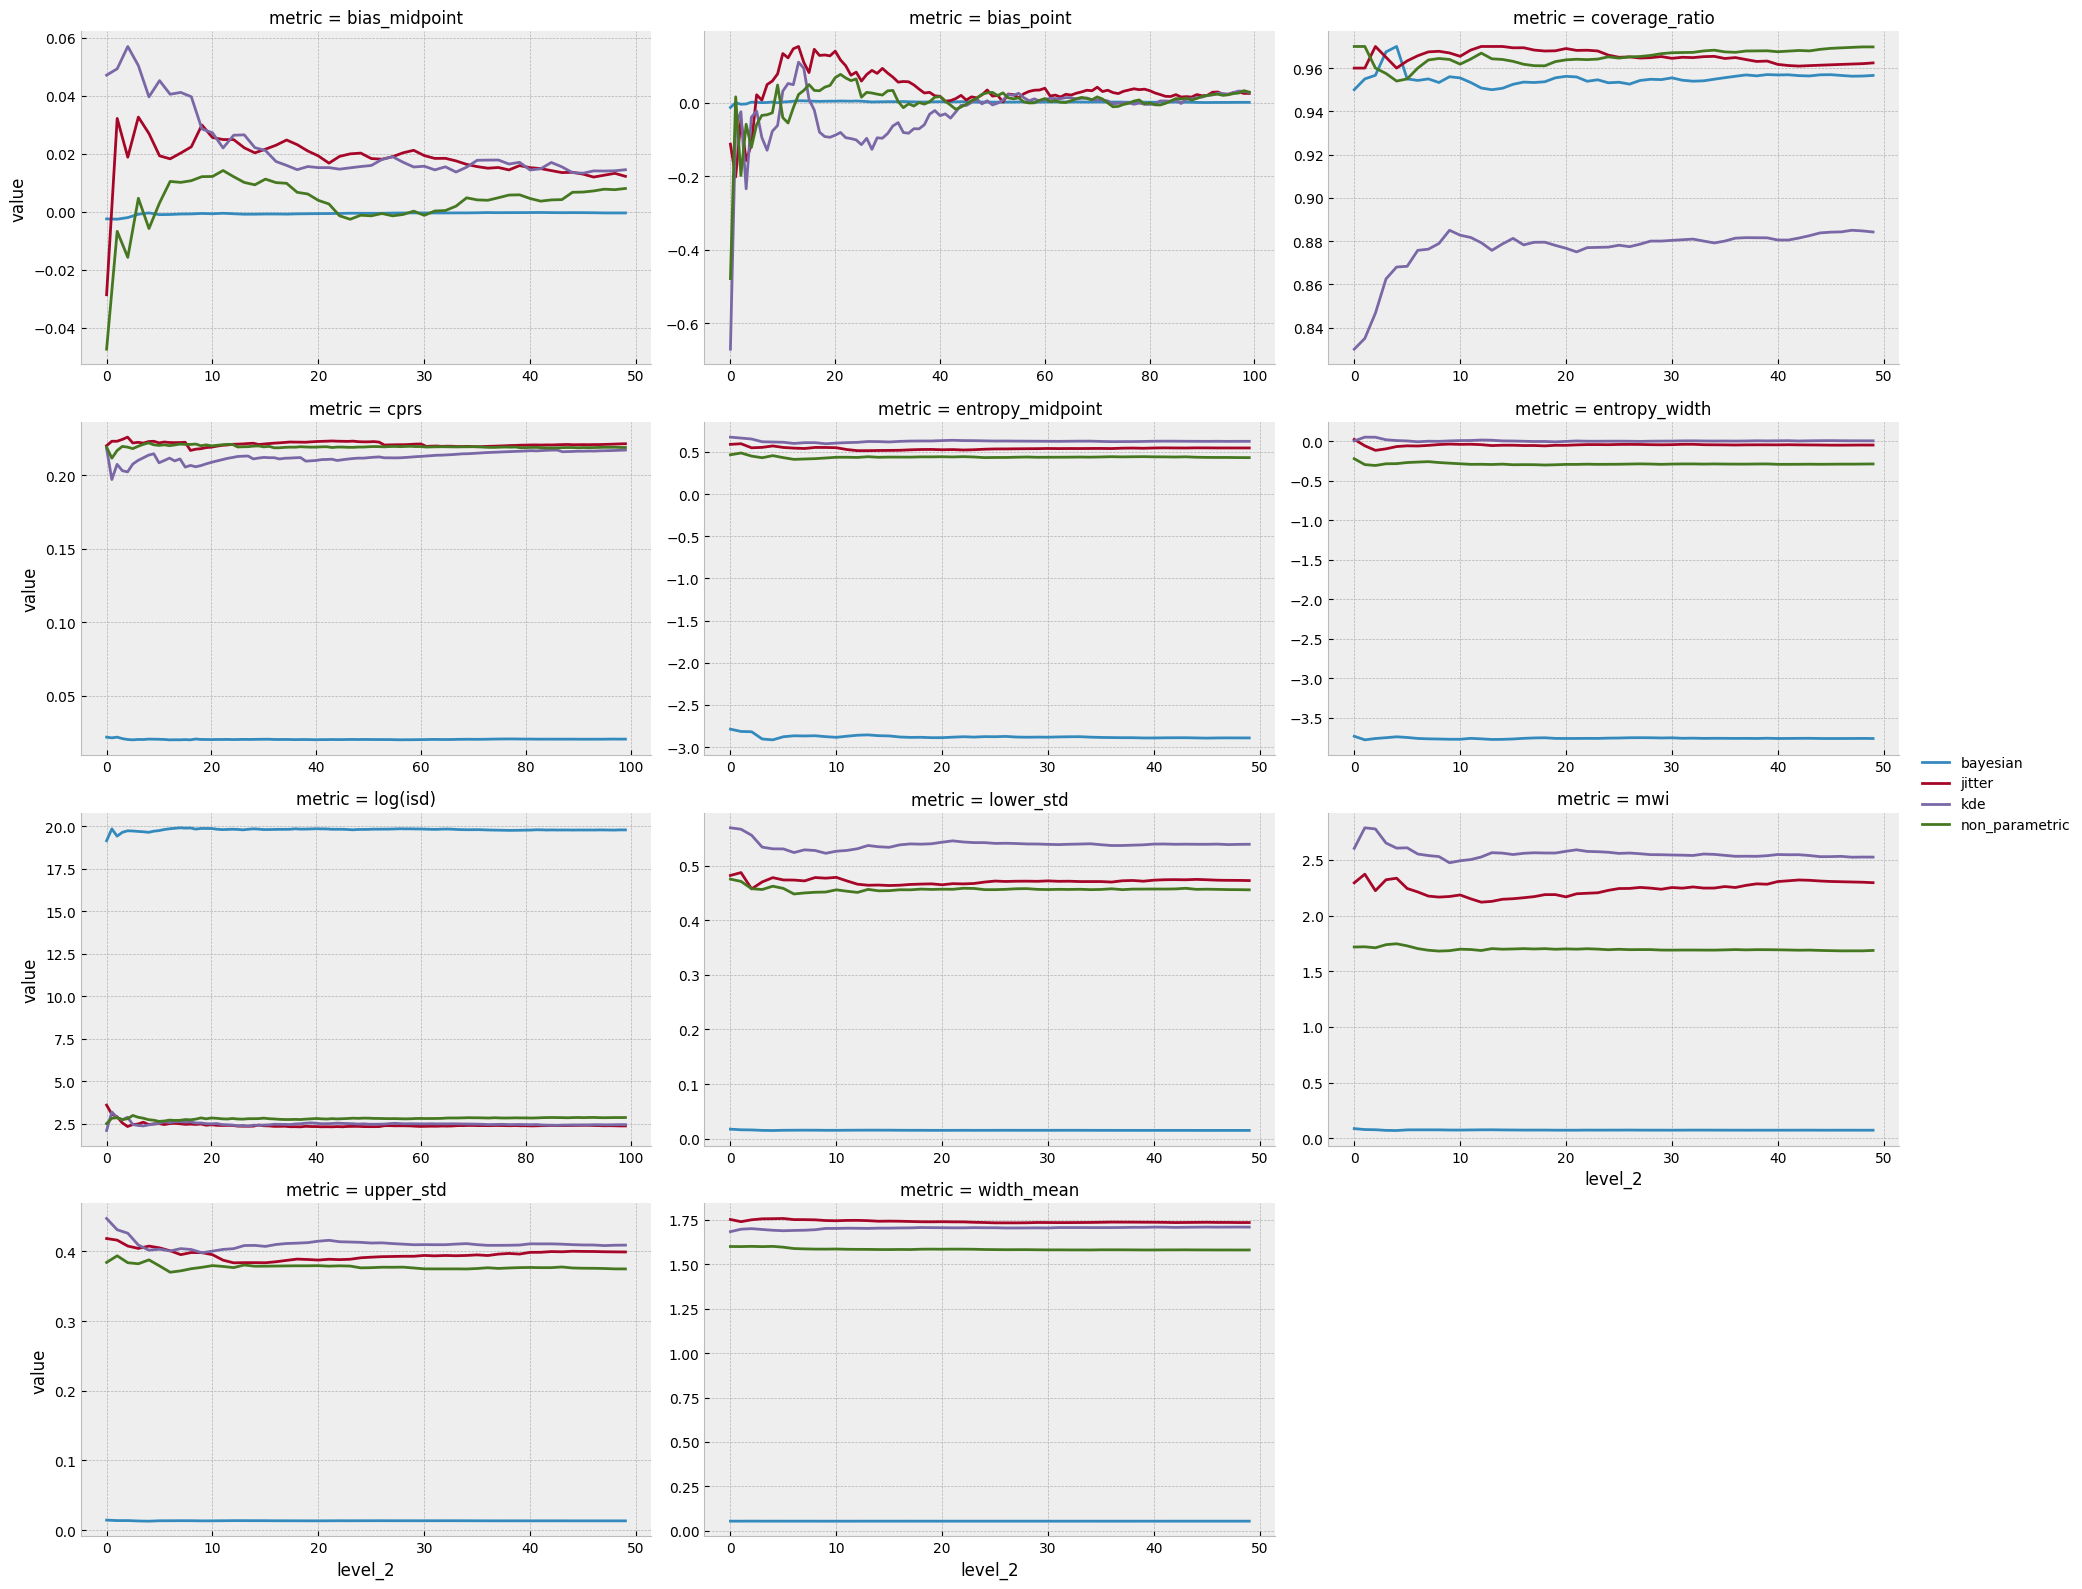

In [73]:
facet = sns.FacetGrid(
    data=stabilization_df,
    col="metric",
    height=4,
    aspect=1.61,
    sharex=False,
    sharey=False,
    col_wrap=3,
)
facet.map_dataframe(sns.lineplot, x="level_2", hue="method", y="value")
facet.add_legend();